In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

/Users/kientran/opt/anaconda3/envs/dl_hw3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import skimage.io as io
from pycocotools.coco import COCO
import deeplake

In [4]:
# Insert root directory of the project (parent of current directory) into the path for imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


In [5]:
from preprocessing.utils import MaskedDataset

In [11]:
dataDir = '../data'
masks_folder_path = '256sq_10_20'

## 1. Extract continuous mask from Coco dataset

In [8]:
# 1. Get segmentation masks from the Coco dataset

# Specify the paths to the COCO dataset and annotations
dataType = 'val2017'
annFile = os.path.join(dataDir, 'annotations', 'instances_{}.json'.format(dataType))

# Initialize the COCO API for the validation set
coco = COCO(annFile)

imgIds = coco.getImgIds()
print(len(imgIds))

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
5000


In [7]:
# define a function to filter out images with dimensions less than 256x256
def filter_images(imgIds):
    filtered_imgIds = []
    for imgId in imgIds:
        img = coco.loadImgs(imgId)[0]
        if img['width'] >= 256 and img['height'] >= 256:
            filtered_imgIds.append(imgId)
    return filtered_imgIds
# define a function to crop images to 256x256 in the center
def crop_images(numpy_image):
    if len(numpy_image.shape) == 2:
        height, width = numpy_image.shape
        start_height = (height - 256) // 2
        start_width = (width - 256) // 2
        return numpy_image[start_height:start_height+256, start_width:start_width+256]
    elif len(numpy_image.shape) == 3:
        height, width, _ = numpy_image.shape
        start_height = (height - 256) // 2
        start_width = (width - 256) // 2
        return numpy_image[start_height:start_height+256, start_width:start_width+256, :]
# define a function to check if mask area ratio is between 0.2 and 0.3
def check_mask_area_ratio(mask, min_area_ratio=0.2, max_area_ratio=0.3):
    return min_area_ratio <= np.sum(mask) / (mask.shape[0] * mask.shape[1]) <= max_area_ratio


In [9]:
filtered_imgIds = filter_images(imgIds)

# Loop over the images in the validation set and download the segmentation masks
for imgId in filtered_imgIds:
    # Load the image
    img = coco.loadImgs(imgId)[0]
    # Load the annotations for the image
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    # Create a binary mask for each object in the image
    masks = []
    for ann in anns:
        mask = coco.annToMask(ann)
        cropped_mask = crop_images(mask)
        if check_mask_area_ratio(cropped_mask, min_area_ratio=0.1, max_area_ratio=0.2):
            masks.append(cropped_mask)
    # Save the masks as binary numpy arrays
    for i, mask in enumerate(masks):
        mask_file = os.path.join(dataDir, 'masks', masks_folder_path, '{}_{}.npy'.format(img['file_name'].split('.')[0], i))
        np.save(mask_file, mask)


## 2. Create a dataloader to handle input data

In [6]:
ds = deeplake.load("hub://activeloop/places205")


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/places205



/

hub://activeloop/places205 loaded successfully.



In [12]:
# Now we have a bunch of masks in the data/masks/256sq_10_20 folder. Let's load them into a numpy array
# Get all file names in the masks folder
mask_files = os.listdir(os.path.join(dataDir, 'masks', masks_folder_path))
# Create a numpy array to store the masks
masks = np.zeros((len(mask_files), 256, 256))
# Loop over the mask files and load them into the numpy array
for i, mask_file in enumerate(mask_files):
    mask = np.load(os.path.join(dataDir, 'masks', masks_folder_path, mask_file))
    masks[i] = mask
print(masks.shape)

(1957, 256, 256)


In [13]:
m_ds = MaskedDataset(ds=ds, mask_array= masks)

dataloader_pytroch = DataLoader(m_ds, batch_size = 2, num_workers = 1, shuffle = False)

images torch.Size([2, 256, 256, 3])
masked_images torch.Size([2, 256, 256, 3])
labels torch.Size([2, 1])


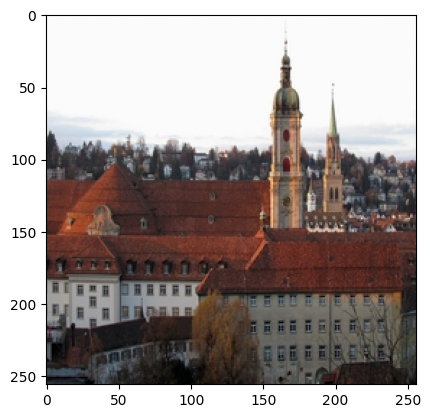

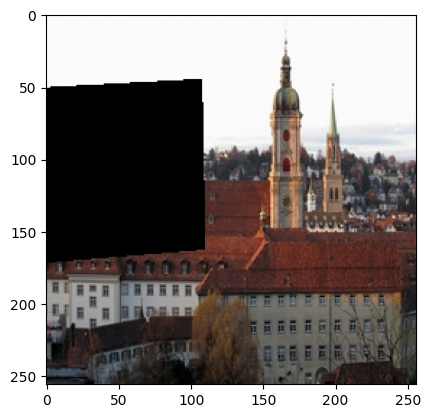

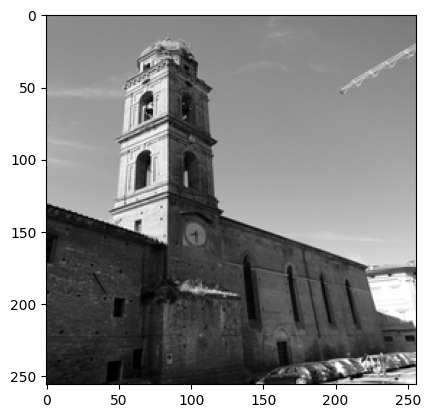

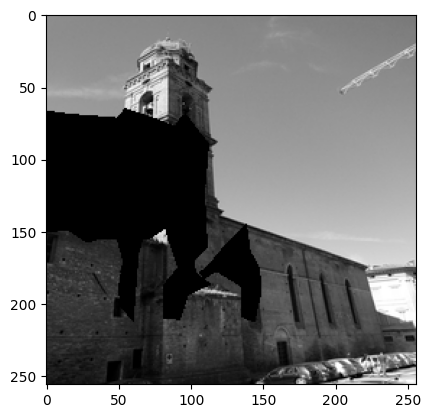

In [14]:
for i, sample in enumerate(dataloader_pytroch):
    if i == 0:
        print("images", sample['images'].shape)
        print("masked_images", sample['masked_images'].shape)
        print("labels", sample['labels'].shape)
        for j in range(2):
            plt.imshow(sample['images'][j])
            plt.show()
            plt.imshow(sample['masked_images'][j])
            plt.show()
        # print(sample)
    break